# **Installing Necessary Libraries**

In [1]:
!pip install -q git+https://github.com/huggingface/transformers

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [2]:
!pip install -q git+https://github.com/huggingface/datasets

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [3]:
!pip install -q git+https://github.com/huggingface/accelerate

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [4]:
!pip install -q ipython-autotime

In [5]:

%load_ext autotime

time: 303 µs (started: 2023-09-07 20:32:24 +00:00)


In [6]:
!pip install -q evaluate

time: 4.72 s (started: 2023-09-07 20:32:24 +00:00)


# **Import Necessary Libraries**

In [7]:
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Hugging Face Transformers and Datasets libraries
import datasets
from datasets import Dataset, DatasetDict
import torch
import transformers
from transformers import AutoModelForSequenceClassification, AutoTokenizer, TrainingArguments, Trainer, set_seed, DataCollatorWithPadding

# Evaluation Module
import evaluate




time: 6.02 s (started: 2023-09-07 20:32:29 +00:00)


In [8]:
# Setting Seed
set_seed(42)

time: 2.89 ms (started: 2023-09-07 20:32:35 +00:00)


# **Library Versions**

In [9]:
library_versions = {
    "Python": sys.version.split()[0],
    "NumPy": np.__version__,
    "Pandas": pd.__version__,
    "Datasets": datasets.__version__,
    "Transformers": transformers.__version__,
    "Torch": torch.__version__,
    "Evaluate": evaluate.__version__,
}

for name, version in library_versions.items():
    print(name.rjust(15), ":", version)

         Python : 3.10.12
          NumPy : 1.23.5
         Pandas : 1.5.3
       Datasets : 2.14.6.dev0
   Transformers : 4.34.0.dev0
          Torch : 2.0.1+cu118
       Evaluate : 0.4.0
time: 817 µs (started: 2023-09-07 20:32:35 +00:00)


In [10]:
!nvidia-smi

Thu Sep  7 20:32:35 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A100-SXM...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   32C    P0    43W / 400W |      0MiB / 40960MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# **Loading Dataset**

In [11]:
!pip install -q opendatasets

time: 4.62 s (started: 2023-09-07 20:32:35 +00:00)


In [12]:
import opendatasets as od

time: 15.4 ms (started: 2023-09-07 20:32:40 +00:00)


In [13]:
od.download('https://www.kaggle.com/datasets/subhajournal/normal-hate-and-offensive-speeches')

Skipping, found downloaded files in "./normal-hate-and-offensive-speeches" (use force=True to force download)
time: 1.06 ms (started: 2023-09-07 20:32:40 +00:00)


# **Concatenating Data from Various CSV Files**

In [14]:
parent_dir = "/content/normal-hate-and-offensive-speeches"

unique_classes = ["Normal", "Hate", "Offensive"]


# Use list comprehension to generate list of DataFrames
dfs = [
    pd.read_csv(
        os.path.join(parent_dir, f"{class_name}_Speeches_{x + 1}.csv"),
        usecols=[3]
    ).assign(label=class_name)
    for class_name in unique_classes
    for x in range(4)
]

# Concatenate all DataFrames
data = pd.concat(dfs, ignore_index=True)

# Rename column
data.rename(columns={"full_text": "text"}, inplace=True)

print(data)


                                                   text      label
0     Freedom is poetry, taking liberties with words...     Normal
1     How is going,Biu?Are you passing peacefully an...     Normal
2     u got ball sniffer on your team ofc u would fi...     Normal
3     The sensible normal British public have had en...     Normal
4     There is a conspiracy to declare all concerned...     Normal
...                                                 ...        ...
3056  @SafeStreetRebel I just argued that police sho...  Offensive
3057  @DougSides @Fla_Pol @AGGancarski When we begin...  Offensive
3058  There are people supporting Mall of America ha...  Offensive
3059  Outlawing speech , any kind of speech is wrong...  Offensive
3060  #algeria MUST be condemned for this offensive,...  Offensive

[3061 rows x 2 columns]
time: 74.8 ms (started: 2023-09-07 20:32:40 +00:00)


# **Label Distribution**

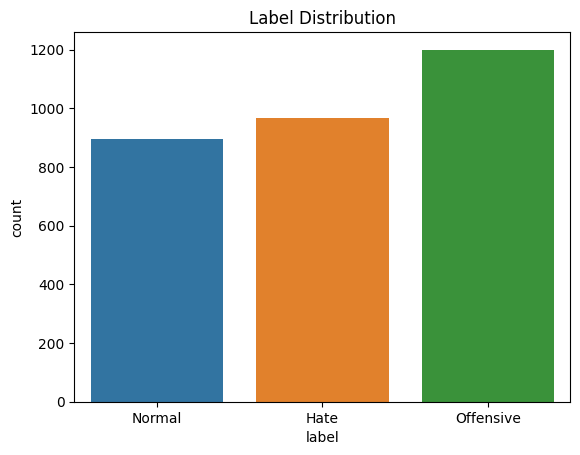

time: 187 ms (started: 2023-09-07 20:32:40 +00:00)


In [15]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.countplot(data=data, x='label')
plt.title('Label Distribution')
plt.show()


# **Wordcloud for Normal, Hate and Offensive Speech**

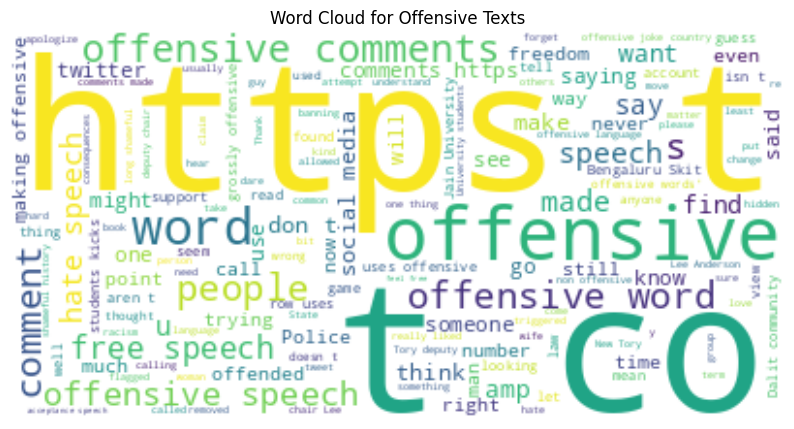

time: 618 ms (started: 2023-09-07 20:32:40 +00:00)


In [16]:
from wordcloud import WordCloud

offensive_text = ' '.join(data[data['label'] == 'Offensive']['text'].tolist())
wordcloud = WordCloud(background_color='white').generate(offensive_text)

plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for Offensive Texts')
plt.show()


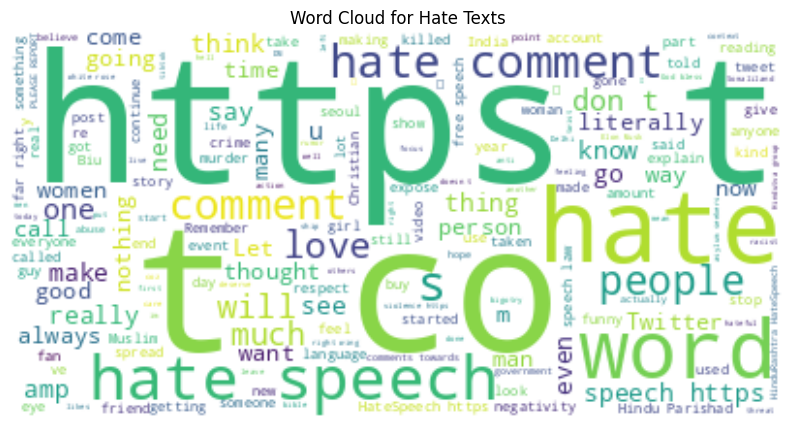

time: 646 ms (started: 2023-09-07 20:32:41 +00:00)


In [17]:
from wordcloud import WordCloud

hate_text = ' '.join(data[data['label'] == 'Hate']['text'].tolist())
wordcloud = WordCloud(background_color='white').generate(hate_text)

plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for Hate Texts')
plt.show()


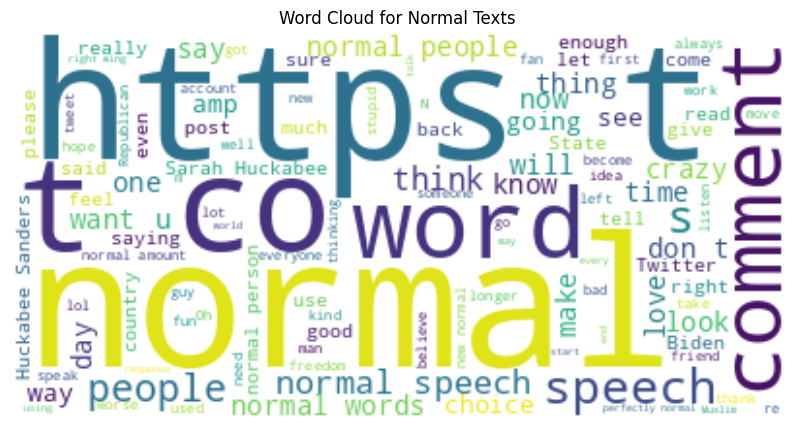

time: 526 ms (started: 2023-09-07 20:32:41 +00:00)


In [18]:
from wordcloud import WordCloud

normal_text = ' '.join(data[data['label'] == 'Normal']['text'].tolist())
wordcloud = WordCloud(background_color='white').generate(normal_text)

plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for Normal Texts')
plt.show()


# **Text Length Distribution**

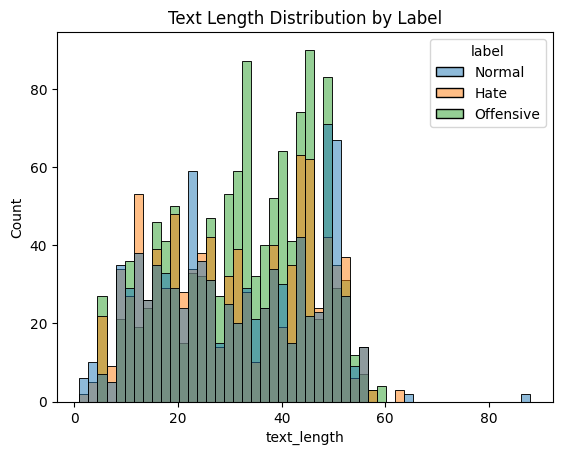

time: 454 ms (started: 2023-09-07 20:32:42 +00:00)


In [19]:
data['text_length'] = data['text'].str.split().str.len()

sns.histplot(data=data, x='text_length', hue='label', bins=50)
plt.title('Text Length Distribution by Label')
plt.show()


# **Boxplot for Text Length**

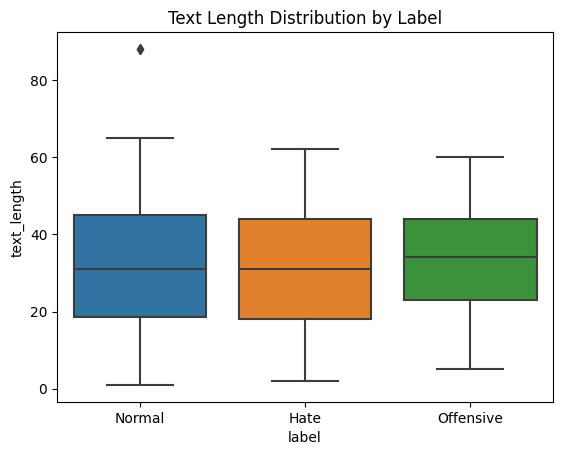

time: 154 ms (started: 2023-09-07 20:32:42 +00:00)


In [20]:
sns.boxplot(data=data, x='label', y='text_length')
plt.title('Text Length Distribution by Label')
plt.show()


In [21]:
grouped = data.groupby('label')['text_length']

max_lengths = grouped.max()
min_lengths = grouped.min()
avg_lengths = grouped.mean()

print("Max Text Lengths by Label:")
print(max_lengths)
print("\nMin Text Lengths by Label:")
print(min_lengths)
print("\nAverage Text Lengths by Label:")
print(avg_lengths)


Max Text Lengths by Label:
label
Hate         62
Normal       88
Offensive    60
Name: text_length, dtype: int64

Min Text Lengths by Label:
label
Hate         2
Normal       1
Offensive    5
Name: text_length, dtype: int64

Average Text Lengths by Label:
label
Hate         30.709110
Normal       31.348603
Offensive    33.010000
Name: text_length, dtype: float64
time: 4.88 ms (started: 2023-09-07 20:32:43 +00:00)


# **Why have we Avoided Converting to Lowercase and Eliminating Special Characters?**
1. There's a possibility that the case of a word carries meaningful information (for instance, if capitalized words are used more frequently in certain types of speech in dataset), then lowercasing should be avoided... that's exactly what we are going to do..
2. In certain contexts like hate speech or offensive language detection, users might obfuscate words with special characters to bypass content filters. In such cases, simply removing these characters might strip away essential information.

# **Label-Specific Threshold Filtering**

In [22]:
condition_hate = (data['label'] == 'Hate') & (data['text_length'] <= 62)
condition_offensive = (data['label'] == 'Offensive') & (data['text_length'] <= 60)
condition_normal = (data['label'] == 'Normal') & (data['text_length'] <= 88)

data = data[condition_hate | condition_offensive | condition_normal]


time: 3.31 ms (started: 2023-09-07 20:32:43 +00:00)


In [23]:
data

,text,label,text_length
0,"Freedom is poetry, taking liberties with words...",Normal,27
1,"How is going,Biu?Are you passing peacefully an...",Normal,45
2,u got ball sniffer on your team ofc u would fi...,Normal,16
3,The sensible normal British public have had en...,Normal,47
4,There is a conspiracy to declare all concerned...,Normal,23
...,...,...,...
3056,@SafeStreetRebel I just argued that police sho...,Offensive,12
3057,@DougSides @Fla_Pol @AGGancarski When we begin...,Offensive,49
3058,There are people supporting Mall of America ha...,Offensive,49
3059,"Outlawing speech , any kind of speech is wrong...",Offensive,44


time: 7.4 ms (started: 2023-09-07 20:32:43 +00:00)


In [24]:
label_counts = data['label'].value_counts()
print(label_counts)


Offensive    1200
Hate          966
Normal        895
Name: label, dtype: int64
time: 1.64 ms (started: 2023-09-07 20:32:43 +00:00)


In [25]:
data.drop(columns=["text_length"], inplace=True)

time: 1.14 ms (started: 2023-09-07 20:32:43 +00:00)


In [26]:
data

,text,label
0,"Freedom is poetry, taking liberties with words...",Normal
1,"How is going,Biu?Are you passing peacefully an...",Normal
2,u got ball sniffer on your team ofc u would fi...,Normal
3,The sensible normal British public have had en...,Normal
4,There is a conspiracy to declare all concerned...,Normal
...,...,...
3056,@SafeStreetRebel I just argued that police sho...,Offensive
3057,@DougSides @Fla_Pol @AGGancarski When we begin...,Offensive
3058,There are people supporting Mall of America ha...,Offensive
3059,"Outlawing speech , any kind of speech is wrong...",Offensive


time: 5.83 ms (started: 2023-09-07 20:32:43 +00:00)


# **Checking Label Distribution After Filtering/Pre-processing**

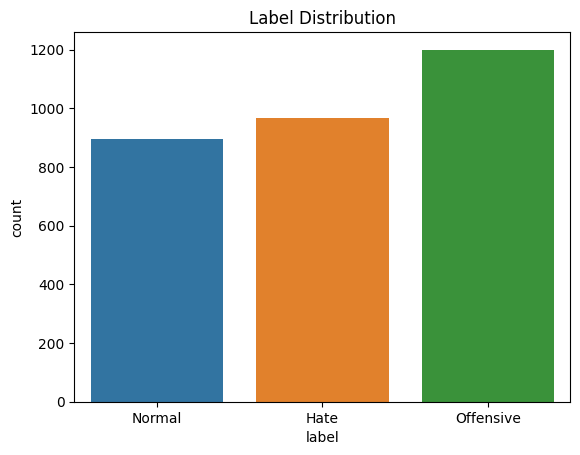

time: 141 ms (started: 2023-09-07 20:32:43 +00:00)


In [27]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.countplot(data=data, x='label')
plt.title('Label Distribution')
plt.show()


Remark: Severe Imbalace isn't there!

# **Creating id2label and label2id dictionaries**

In [28]:
# Using dictionary comprehensions to create id2label and label2id dictionaries
id2label = {idx: label for idx, label in enumerate(unique_classes)}
label2id = {label: idx for idx, label in enumerate(unique_classes)}

NUM_OF_LABELS = len(unique_classes)
NUM_OF_LABELS


3

time: 2.79 ms (started: 2023-09-07 20:32:43 +00:00)


# **Converting Class Values From String to Integer & Convert DataFrame to Dataset**

In [29]:
data = data.replace(label2id)

dataset = Dataset.from_pandas(data)

time: 10.6 ms (started: 2023-09-07 20:32:43 +00:00)


# **Splitting the Dataset**

Note: Since the dataset size is small, we'll split the dataset into train and eval set only.

In [30]:
train_eval = dataset.train_test_split(train_size=0.80)

ds = DatasetDict({
    'train' : train_eval['train'],
    'eval' : train_eval['test'],
})

print("Training Dataset Shape:", ds['train'].shape)
print("Evaluation Dataset Shape:", ds['eval'].shape)

Training Dataset Shape: (2448, 3)
Evaluation Dataset Shape: (613, 3)
time: 7.17 ms (started: 2023-09-07 20:32:43 +00:00)


In [31]:
train_test_valid = dataset.train_test_split(train_size=0.80)
test_eval = train_test_valid['test'].train_test_split(train_size=0.50)

ds = DatasetDict({
    'train' : train_test_valid['train'],
    'test' : test_eval['train'],
    'eval' : test_eval['test'],
})

print("Training Dataset Shape:", ds['train'].shape)
print("Testing Dataset Shape:", ds['test'].shape)
print("Evaluation Dataset Shape:", ds['eval'].shape)

Training Dataset Shape: (2448, 3)
Testing Dataset Shape: (306, 3)
Evaluation Dataset Shape: (307, 3)
time: 16.5 ms (started: 2023-09-07 20:32:43 +00:00)


In [32]:
NUM_OF_EPOCHS = 5

BATCH_SIZE = 16
LEARNING_RATE = 2e-5

MAX_LENGTH = int(88 * 1.3)
MODEL_CKPT = "distilbert-base-uncased"
MODEL_NAME = MODEL_CKPT.split("/")[-1] + f"-hate-offensive-normal-speech-lr-{LEARNING_RATE}"

METRIC_NAME = "f1"

time: 512 µs (started: 2023-09-07 20:32:43 +00:00)


# **Tokenizing Dataset**

In [33]:
# Define Tokenizer
tokenizer = AutoTokenizer.from_pretrained(MODEL_CKPT)

# Tokenize Method
def tokenize(batch):
    return tokenizer(batch['text'],
                     padding=True,
                     truncation=True,
                     max_length=MAX_LENGTH,
                     return_tensors="pt")

# Map tokenizer method to entire dataset
encoded_data = ds.map(tokenize, batched=True, batch_size=None)  # for larger datasets, we'll likely need to set a specific batch size. here we are batching all at once

print('training data shape:', encoded_data['train'].shape)
print('testing data shape:', encoded_data['test'].shape)
print('validation data shape:', encoded_data['eval'].shape)

print(encoded_data['train'].features)
print(encoded_data['train'])

print(encoded_data['train'].features)
print(encoded_data['train'])

Map:   0%|          | 0/2448 [00:00<?, ? examples/s]

Map:   0%|          | 0/306 [00:00<?, ? examples/s]

Map:   0%|          | 0/307 [00:00<?, ? examples/s]

training data shape: (2448, 5)
testing data shape: (306, 5)
validation data shape: (307, 5)
{'text': Value(dtype='string', id=None), 'label': Value(dtype='int64', id=None), '__index_level_0__': Value(dtype='int64', id=None), 'input_ids': Sequence(feature=Value(dtype='int32', id=None), length=-1, id=None), 'attention_mask': Sequence(feature=Value(dtype='int8', id=None), length=-1, id=None)}
Dataset({
    features: ['text', 'label', '__index_level_0__', 'input_ids', 'attention_mask'],
    num_rows: 2448
})
{'text': Value(dtype='string', id=None), 'label': Value(dtype='int64', id=None), '__index_level_0__': Value(dtype='int64', id=None), 'input_ids': Sequence(feature=Value(dtype='int32', id=None), length=-1, id=None), 'attention_mask': Sequence(feature=Value(dtype='int8', id=None), length=-1, id=None)}
Dataset({
    features: ['text', 'label', '__index_level_0__', 'input_ids', 'attention_mask'],
    num_rows: 2448
})
time: 1.28 s (started: 2023-09-07 20:32:43 +00:00)


# **Instantiate Model**

In [34]:
DEVICE= "cuda"

time: 422 µs (started: 2023-09-07 20:32:44 +00:00)


In [35]:
model = (
    AutoModelForSequenceClassification.from_pretrained(
        MODEL_CKPT,
        num_labels=NUM_OF_LABELS
    ).to(DEVICE))

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.weight', 'classifier.bias', 'classifier.weight', 'pre_classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


time: 2.41 s (started: 2023-09-07 20:32:44 +00:00)


# **Compute Metrics**

In [36]:
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score

def compute_metrics(p):
    predictions = np.argmax(p.predictions, axis=1)
    references = p.label_ids

    results = {
        "accuracy": accuracy_score(references, predictions)
    }

    for average_type in ["weighted", "micro", "macro"]:
        results[f"{average_type.capitalize()} F1"] = f1_score(references, predictions, average=average_type)
        results[f"{average_type.capitalize()} Recall"] = recall_score(references, predictions, average=average_type)
        results[f"{average_type.capitalize()} Precision"] = precision_score(references, predictions, average=average_type)

    return results


time: 701 µs (started: 2023-09-07 20:32:46 +00:00)


# **Defining Training Arguments**

In [37]:
training_args = TrainingArguments(
    output_dir=MODEL_NAME,
    num_train_epochs=NUM_OF_EPOCHS,
    learning_rate=LEARNING_RATE,
    per_device_train_batch_size=BATCH_SIZE,
    per_device_eval_batch_size=BATCH_SIZE,
    log_level="error",
    logging_strategy='epoch',
    evaluation_strategy="epoch",
    save_strategy="epoch",
    logging_first_step=True,
    load_best_model_at_end=True,
    disable_tqdm=False,
    push_to_hub=True
)

time: 3.25 ms (started: 2023-09-07 20:32:47 +00:00)


# **Defining Data Collator**

In [38]:
data_collator = DataCollatorWithPadding(tokenizer, padding=True)

time: 305 µs (started: 2023-09-07 20:32:47 +00:00)


# **Handling Mild Class Imbalance**

In [39]:
total_samples = 1200 + 966 + 895
weights = torch.tensor([total_samples/1200, total_samples/966, total_samples/895])

# Normalize the weights for numerical stability
weights = weights / weights.sum()

weights = weights.to(DEVICE)


class CustomTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False):
        labels = inputs.get("labels")
        outputs = model(**inputs)
        logits = outputs.get("logits")
        loss_fct = torch.nn.CrossEntropyLoss(weight=weights)
        loss = loss_fct(logits.view(-1, self.model.config.num_labels), labels.view(-1))
        return (loss, outputs) if return_outputs else loss

time: 1.94 ms (started: 2023-09-07 20:32:47 +00:00)


# **Instantiating Trainer**

In [40]:
from huggingface_hub import notebook_login
notebook_login()

time: 18.8 ms (started: 2023-09-07 20:32:47 +00:00)


In [41]:
trainer = CustomTrainer(model=model,
                  args=training_args,
                  compute_metrics=compute_metrics,
                  train_dataset=encoded_data['train'],
                  eval_dataset=encoded_data['eval'],
                  data_collator=data_collator,
                  tokenizer=tokenizer)

time: 208 ms (started: 2023-09-07 20:32:47 +00:00)


In [42]:
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,Weighted f1,Weighted recall,Weighted precision,Micro f1,Micro recall,Micro precision,Macro f1,Macro recall,Macro precision
1,0.501300,0.091424,0.964169,0.964344,0.964169,0.964903,0.964169,0.964169,0.964169,0.962894,0.963946,0.962263
2,0.092400,0.031351,0.993485,0.993506,0.993485,0.993629,0.993485,0.993485,0.993485,0.993179,0.993796,0.992674
3,0.043200,0.029839,0.986971,0.987030,0.986971,0.987531,0.986971,0.986971,0.986971,0.986011,0.986851,0.985663
4,0.021700,0.025857,0.990228,0.990268,0.990228,0.990547,0.990228,0.990228,0.990228,0.989595,0.990323,0.989130
5,0.014800,0.017811,0.993485,0.993506,0.993485,0.993629,0.993485,0.993485,0.993485,0.993179,0.993796,0.992674


TrainOutput(global_step=765, training_loss=0.13548065758998099, metrics={'train_runtime': 46.2701, 'train_samples_per_second': 264.534, 'train_steps_per_second': 16.533, 'total_flos': 361021495590720.0, 'train_loss': 0.13548065758998099, 'epoch': 5.0})

time: 53.9 s (started: 2023-09-07 20:32:47 +00:00)


# **Save Model & Metrics on Training Dataset**

In [43]:
trainer.save_model()
trainer.save_state()

time: 2.67 s (started: 2023-09-07 20:33:41 +00:00)


# **Evaluate Model**

In [44]:
metrics = trainer.evaluate(encoded_data['eval'])
trainer.log_metrics("eval", metrics)
trainer.save_metrics("eval", metrics)

***** eval metrics *****
  epoch                   =        5.0
  eval_Macro F1           =     0.9932
  eval_Macro Precision    =     0.9927
  eval_Macro Recall       =     0.9938
  eval_Micro F1           =     0.9935
  eval_Micro Precision    =     0.9935
  eval_Micro Recall       =     0.9935
  eval_Weighted F1        =     0.9935
  eval_Weighted Precision =     0.9936
  eval_Weighted Recall    =     0.9935
  eval_accuracy           =     0.9935
  eval_loss               =     0.0178
  eval_runtime            = 0:00:00.35
  eval_samples_per_second =    863.057
  eval_steps_per_second   =     56.225
time: 365 ms (started: 2023-09-07 20:33:43 +00:00)


# **Push to Hub**

In [45]:
trainer.push_to_hub()

'https://huggingface.co/DrishtiSharma/distilbert-base-uncased-hate-offensive-normal-speech-lr-2e-05/tree/main/'

time: 3.09 s (started: 2023-09-07 20:33:44 +00:00)


In [49]:
from transformers import BertTokenizer, BertForSequenceClassification
import torch

# Load model and tokenizer
model_name = "DrishtiSharma/distilbert-base-uncased-hate-offensive-normal-speech-lr-2e-05"
model = BertForSequenceClassification.from_pretrained(model_name)
tokenizer = BertTokenizer.from_pretrained(model_name)




ValueError: ignored

time: 5.32 s (started: 2023-09-07 20:34:58 +00:00)


In [51]:
# Create a function to make predictions
def predict(text):
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=256)
    with torch.no_grad():
        logits = model(**inputs).logits
    probs = logits.softmax(dim=-1)
    label = torch.argmax(probs, dim=1).item()
    labels_map = {0: "Normal", 1: "Hate", 2: "Offensive"}
    return labels_map[label]

# Example usage
text = "I'm revolving around the moon"
predicted_label = predict(text)
print(f"The text is classified as: {predicted_label}")

The text is classified as: Normal
time: 118 ms (started: 2023-09-07 20:35:11 +00:00)


In [50]:
# Example usage
text = "nigga"
predicted_label = predict(text)
print(f"The text is classified as: {predicted_label}")

The text is classified as: Hate
time: 98 ms (started: 2023-09-07 20:35:04 +00:00)
